In [1]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import ToTensor
import os
import xml.etree.ElementTree as ET
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, annotations_dir, transform=None):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        img = Image.open(img_path).convert("RGB")
        img_tensor = ToTensor()(img)
        
        # Load annotation
        annotation_path = os.path.join(self.annotations_dir, img_name.replace('.jpg', '.xml'))
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        
        boxes = []
        labels = []
        for obj in root.findall('object'):
            name = obj.find('name').text
            if name != 'car':  # Skip if not 'car'
                continue
            bbox = obj.find('bndbox')
            xmin = float(bbox.find('xmin').text)
            ymin = float(bbox.find('ymin').text)
            xmax = float(bbox.find('xmax').text)
            ymax = float(bbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # Label 1 for 'car' (0 is background)
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx]),
            "area": (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
            "iscrowd": torch.zeros((len(labels),), dtype=torch.int64)
        }
        
        if self.transform:
            img_tensor = self.transform(img_tensor)
        
        return img_tensor, target

In [3]:
images_dir = "data/training_images"
annotations_dir = "data/annotations"

# Create dataset and split into train and validation
dataset = VOCDataset(images_dir, annotations_dir)
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Load pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)

D:\AI-ML classes\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\AI-ML classes\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
num_classes = 2  # 1 class (car) + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Move model to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [6]:
num_epochs = 10
model.train()
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Training)"):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        epoch_train_loss += losses.item()
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Training Loss: {avg_train_loss:.4f}")

    # Validation phase
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Validation)"):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Temporarily enable training mode to compute losses
            model.train()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            model.eval()  # Switch back to evaluation mode
            
            epoch_val_loss += losses.item()
    
    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Validation Loss: {avg_val_loss:.4f}")

# Save the fine-tuned model
torch.save(model.state_dict(), "faster_rcnn_finetuned.pth")
print("Model saved as faster_rcnn_finetuned.pth")

Epoch 1/10 (Training): 100%|████████████████████████████████████████████████████████████████| 142/142 [01:28<00:00,  1.61it/s]


Epoch 1/10, Average Training Loss: 0.1118


Epoch 1/10 (Validation): 100%|████████████████████████████████████████████████████████████████| 36/36 [00:10<00:00,  3.28it/s]


Epoch 1/10, Average Validation Loss: 0.1319


Epoch 2/10 (Training): 100%|████████████████████████████████████████████████████████████████| 142/142 [01:31<00:00,  1.55it/s]


Epoch 2/10, Average Training Loss: 0.0927


Epoch 2/10 (Validation): 100%|████████████████████████████████████████████████████████████████| 36/36 [00:10<00:00,  3.46it/s]


Epoch 2/10, Average Validation Loss: 0.1050


Epoch 3/10 (Training): 100%|████████████████████████████████████████████████████████████████| 142/142 [01:30<00:00,  1.57it/s]


Epoch 3/10, Average Training Loss: 0.0813


Epoch 3/10 (Validation): 100%|████████████████████████████████████████████████████████████████| 36/36 [00:10<00:00,  3.53it/s]


Epoch 3/10, Average Validation Loss: 0.1122


Epoch 4/10 (Training): 100%|████████████████████████████████████████████████████████████████| 142/142 [01:33<00:00,  1.52it/s]


Epoch 4/10, Average Training Loss: 0.0726


Epoch 4/10 (Validation): 100%|████████████████████████████████████████████████████████████████| 36/36 [00:10<00:00,  3.49it/s]


Epoch 4/10, Average Validation Loss: 0.1139


Epoch 5/10 (Training): 100%|████████████████████████████████████████████████████████████████| 142/142 [01:33<00:00,  1.52it/s]


Epoch 5/10, Average Training Loss: 0.0658


Epoch 5/10 (Validation): 100%|████████████████████████████████████████████████████████████████| 36/36 [00:10<00:00,  3.37it/s]


Epoch 5/10, Average Validation Loss: 0.1114


Epoch 6/10 (Training): 100%|████████████████████████████████████████████████████████████████| 142/142 [01:33<00:00,  1.52it/s]


Epoch 6/10, Average Training Loss: 0.0597


Epoch 6/10 (Validation): 100%|████████████████████████████████████████████████████████████████| 36/36 [00:09<00:00,  3.60it/s]


Epoch 6/10, Average Validation Loss: 0.1099


Epoch 7/10 (Training): 100%|████████████████████████████████████████████████████████████████| 142/142 [01:28<00:00,  1.61it/s]


Epoch 7/10, Average Training Loss: 0.0515


Epoch 7/10 (Validation): 100%|████████████████████████████████████████████████████████████████| 36/36 [00:09<00:00,  3.66it/s]


Epoch 7/10, Average Validation Loss: 0.1168


Epoch 8/10 (Training): 100%|████████████████████████████████████████████████████████████████| 142/142 [01:28<00:00,  1.61it/s]


Epoch 8/10, Average Training Loss: 0.0482


Epoch 8/10 (Validation): 100%|████████████████████████████████████████████████████████████████| 36/36 [00:09<00:00,  3.66it/s]


Epoch 8/10, Average Validation Loss: 0.1156


Epoch 9/10 (Training): 100%|████████████████████████████████████████████████████████████████| 142/142 [01:28<00:00,  1.61it/s]


Epoch 9/10, Average Training Loss: 0.0453


Epoch 9/10 (Validation): 100%|████████████████████████████████████████████████████████████████| 36/36 [00:09<00:00,  3.68it/s]


Epoch 9/10, Average Validation Loss: 0.1122


Epoch 10/10 (Training): 100%|███████████████████████████████████████████████████████████████| 142/142 [01:28<00:00,  1.61it/s]


Epoch 10/10, Average Training Loss: 0.0382


Epoch 10/10 (Validation): 100%|███████████████████████████████████████████████████████████████| 36/36 [00:09<00:00,  3.65it/s]


Epoch 10/10, Average Validation Loss: 0.1139
Model saved as faster_rcnn_finetuned.pth


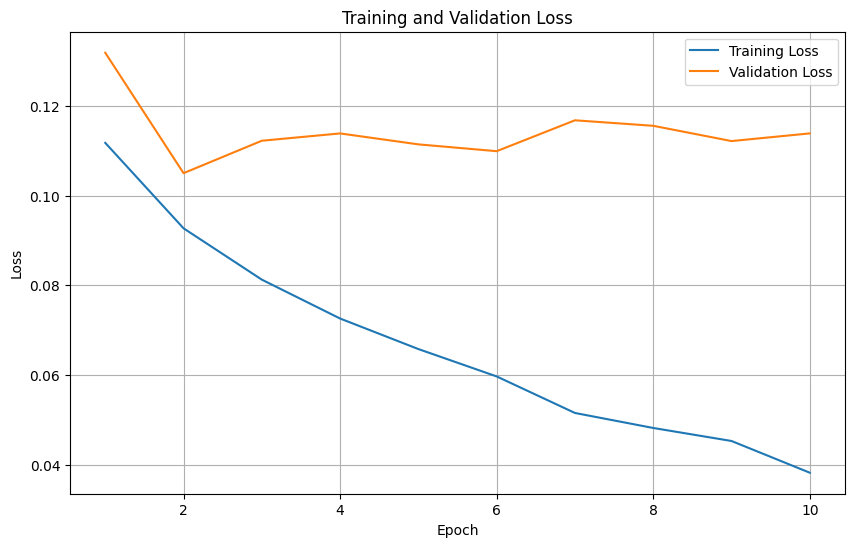

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png')
plt.show()